In [38]:
# Cell 2 - Imports
import os
from dotenv import load_dotenv
from groq import Groq

import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report


In [39]:
# Cell 3 - Configuración para Groq

# Cargar variables del entorno (.env con GROQ_API_KEY=...)
load_dotenv()

# Obtener API KEY de Groq
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if GROQ_API_KEY is None:
    raise ValueError("❌ GROQ_API_KEY no encontrada. Asegúrate de definirla en tu archivo .env")

# Inicializar cliente Groq
client = Groq(api_key=GROQ_API_KEY)

def groq_generate(prompt, model="meta-llama/llama-4-maverick-17b-128e-instruct"):
    """
    Envía el prompt al modelo de Groq y regresa el texto generado.
    """
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a tweet classifier that detects expressions of hope."},
            {"role": "user", "content": prompt},
        ],
        temperature=0.1,
        max_completion_tokens=80,
    )
    return response.choices[0].message.content.strip()


In [40]:
# Cell 4 - Cargar dataset

# Ajusta el nombre del archivo si es necesario
df = pd.read_csv("HSD.csv")

print("✅ Dataset cargado con", len(df), "registros")
df.head()


✅ Dataset cargado con 8256 registros


,text,binary,multiclass
0,#USER# #USER# You can’t solve Nigerias problem...,Not Hope,Not Hope
1,#USER# #USER# #USER# So looking forward to to ...,Hope,Generalized Hope
2,#USER# This is the most runs they’ve scored al...,Not Hope,Not Hope
3,#USER# My point is: any vaccine batches that c...,Not Hope,Not Hope
4,Liberals were happy killing the businesses tha...,Not Hope,Not Hope


In [41]:
# Cell 5 - Subset binario (Hope / Not Hope)

subset = df[df['binary'].isin(['Not Hope', 'Hope'])]

# Tomar 500 de cada clase de forma balanceada
subset_balanceado = (
    subset.groupby('binary', group_keys=False)
          .apply(lambda x: x.sample(n=500, random_state=42))
)

subsetBin = subset_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nConteo en subsetBin (binary):")
print(subsetBin['binary'].value_counts())
print("\nTamaño total de subsetBin:", len(subsetBin))
subsetBin.head()



Conteo en subsetBin (binary):
binary
Not Hope    500
Hope        500
Name: count, dtype: int64

Tamaño total de subsetBin: 1000


C:\Users\Theas\AppData\Local\Temp\ipykernel_11804\3006831097.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=500, random_state=42))


,text,binary,multiclass
0,Did you think they were not going to do it? S...,Not Hope,Not Hope
1,#USER# #USER# We need to do MORE than just vot...,Not Hope,Not Hope
2,Piece looking ahead to Day 2 of #Wimbledon fea...,Not Hope,Not Hope
3,"Check out my new EP ""Count To 3"" distributed b...",Not Hope,Not Hope
4,The government is making difficult decisions r...,Hope,Realistic Hope


In [42]:
# Cell 6 - Subset multiclass (Generalized / Realistic / Unrealistic Hope)

subset = df[df['multiclass'].isin(['Generalized Hope', 'Realistic Hope', 'Unrealistic Hope'])]

subset_balanceado = (
    subset.groupby('multiclass', group_keys=False)
          .apply(lambda x: x.sample(n=334, random_state=42))
)

subsetMulti = subset_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nConteo en subsetMulti (multiclass):")
print(subsetMulti['multiclass'].value_counts())
print("\nTamaño total de subsetMulti:", len(subsetMulti))
display(subsetMulti.head())

# ==========================
#  EXTRA: generar archivo con 50 tweets Unrealistic Hope
# ==========================

unrealistic_subset = subsetMulti[subsetMulti["multiclass"] == "Unrealistic Hope"]

# Tomar 50 (o el máximo disponible si hubiera menos)
sample_unrealistic = unrealistic_subset.sample(
    n=min(50, len(unrealistic_subset)), 
    random_state=42
)

# Guardar en un .txt
output_path = "unrealistic_50.txt"
with open(output_path, "w", encoding="utf-8") as f:
    for tweet in sample_unrealistic["text"]:
        f.write(tweet.strip().replace("\n", " ") + "\n")

print(f"\n📄 Archivo generado: {output_path} con {len(sample_unrealistic)} tweets.")



Conteo en subsetMulti (multiclass):
multiclass
Realistic Hope      334
Unrealistic Hope    334
Generalized Hope    334
Name: count, dtype: int64

Tamaño total de subsetMulti: 1002


C:\Users\Theas\AppData\Local\Temp\ipykernel_11804\3475348048.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=334, random_state=42))


,text,binary,multiclass
0,I was both hoping for &amp; dreading the day t...,Hope,Realistic Hope
1,overheard conversation at target\ngirl: *yelli...,Hope,Unrealistic Hope
2,#USER# #USER# #USER# #USER# How are Black Live...,Hope,Unrealistic Hope
3,#USER# I hope they are on call 24/7 for doctor...,Hope,Realistic Hope
4,Excavation work is expected to begin this week...,Hope,Realistic Hope



📄 Archivo generado: unrealistic_50.txt con 50 tweets.


In [43]:
# Cell 7 - Clasificación binaria por batches

def clasificarBin_batch(lista_textos, prompt_version=1, df=None):
    """
    Clasifica una LISTA de textos en:
    - Hope
    - Not Hope

    Retorna una lista de etiquetas (una por texto).
    """

    definicion_hope = "Hope means expressing optimism, trust, or desire for a better future."

    # Construcción del bloque donde listamos N tweets
    bloque_tweets = "\n".join([f"{i+1}. {texto}" for i, texto in enumerate(lista_textos)])

    # ========= PROMPTS =========
    if prompt_version == 1:
        # 🟢 Zero-shot
        prompt = f"""
Definition: {definicion_hope}

You will receive a numbered list of tweets.
Return EXACTLY ONE LABEL PER LINE, in the same order.
Valid labels:
- Hope
- Not Hope

Tweets:
{bloque_tweets}

Now output ONLY the labels, one per line, with no numbers and no extra text:
"""

    elif prompt_version == 2:
        # 🟣 One-shot
        if df is not None and len(df) > 0:
            ejemplo = df.sample(1).iloc[0]
            ejemplo_text = ejemplo["text"]
            ejemplo_label = ejemplo["binary"]
        else:
            ejemplo_text = "I believe we can overcome these challenges together."
            ejemplo_label = "Hope"

        prompt = f"""
Definition: {definicion_hope}

Example:
Tweet: "{ejemplo_text}"
Label: {ejemplo_label}

You will receive a numbered list of tweets.
Return EXACTLY ONE LABEL PER LINE, in the same order.
Valid labels:
- Hope
- Not Hope

Tweets:
{bloque_tweets}

Now output ONLY the labels, one per line, with no numbers and no extra text:
"""

    else:
        # 🔵 Few-shot
        if df is not None and len(df) > 0:
            ejemplos = df.sample(min(5, len(df)))
            ejemplos_texto = "\n".join(
                [f'"{row["text"]}" → {row["binary"]}' for _, row in ejemplos.iterrows()]
            )
        else:
            ejemplos_texto = '"Things will get better soon." → Hope'

        prompt = f"""
Definition: {definicion_hope}

Examples:
{ejemplos_texto}

You will receive a numbered list of tweets.
Return EXACTLY ONE LABEL PER LINE, in the same order.
Valid labels:
- Hope
- Not Hope

Tweets:
{bloque_tweets}

Now output ONLY the labels, one per line, with no numbers and no extra text:
"""

    raw = groq_generate(prompt)

    # Convertir en lista (una etiqueta por línea, sin vacíos)
    labels = [l.strip() for l in raw.strip().splitlines() if l.strip()]

    # Por si devuelve más/menos de lo esperado, recortamos / rellenamos
    if len(labels) < len(lista_textos):
        labels += ["Not Hope"] * (len(lista_textos) - len(labels))
    elif len(labels) > len(lista_textos):
        labels = labels[:len(lista_textos)]

    return labels


In [44]:
def clasificarMulti_batch(lista_textos, prompt_version=1, df=None):
    """
    Classifies a LIST of texts into EXACTLY ONE of these 3 PROMPT labels:
    - Abstract Hope
    - Realistic Hope
    - Fantasy Wish

    Returns ALWAYS len(lista_textos) labels.
    """

    PROMPT_LABELS = [
        "Abstract Hope",
        "Realistic Hope",
        "Fantasy Wish"
    ]

    # Dataset for shots (mapped to prompt labels)
    df_hope = None
    if df is not None and "multiclass" in df.columns:
        df_hope = df.copy()
        df_hope["prompt_label"] = df_hope["multiclass"].map({
            "Generalized Hope": "Abstract Hope",
            "Realistic Hope": "Realistic Hope",
            "Unrealistic Hope": "Fantasy Wish"
        })
        df_hope = df_hope[df_hope["prompt_label"].notna()]

    # Numbered tweets
    bloque_tweets = "\n".join(f"{i+1}. {t}" for i, t in enumerate(lista_textos))

    RULES = """
CLASSIFICATION RULES:

FANTASY WISH:
- Impossible, miraculous, magical, or unrealistic outcomes.
- Undoing the past, miracles, cosmic or fictional solutions.

REALISTIC HOPE:
- Hope or expectation clearly tied to a specific, real-world situation or event.
- Clearly tied to a concrete context such as a named event, person, institution, date, or upcoming situation.
- The outcome is plausible.
- Refers to something specific that could realistically happen.

ABSTRACT HOPE:
- General, emotional, or symbolic expressions of hope.
- Blessings, prayers, encouragement, or vague optimism.
- NOT clearly tied to a specific event, time, or concrete situation.
- Expresses a feeling or belief rather than a specific expectation.
"""
    # ================= PROMPTS =================

    if prompt_version == 1:  # ZERO-SHOT
        prompt = f"""
Classify each tweet into ONE of:
- Abstract Hope
- Realistic Hope
- Fantasy Wish

{RULES}

Tweets:
{bloque_tweets}

Output ONLY one label per line:
"""

    elif prompt_version == 2:  # ONE-SHOT
        if df_hope is not None and not df_hope.empty:
            ex = df_hope.sample(1).iloc[0]
            ej_text = ex["text"]
            ej_label = ex["prompt_label"]
        else:
            ej_text = "I hope a miracle fixes everything overnight."
            ej_label = "Fantasy Wish"

        prompt = f"""
Classify each tweet into ONE of:
- Abstract Hope
- Realistic Hope
- Fantasy Wish

{RULES}

Example:
"{ej_text}" → {ej_label}

Tweets:
{bloque_tweets}

Output ONLY one label per line:
"""

    else:  # FEW-SHOT
        ejemplos = []
        if df_hope is not None and not df_hope.empty:
            for lbl in PROMPT_LABELS:
                sub = df_hope[df_hope["prompt_label"] == lbl]
                if not sub.empty:
                    r = sub.sample(1).iloc[0]
                    ejemplos.append(f'"{r["text"]}" → {lbl}')
        else:
            ejemplos = [
                '"Better days will come." → Abstract Hope',
                '"If I keep training, I will improve." → Realistic Hope',
                '"A miracle will fix everything tomorrow." → Fantasy Wish'
            ]

        ejemplos_texto = "\n".join(ejemplos)

        prompt = f"""
Classify each tweet into ONE of:
- Abstract Hope
- Realistic Hope
- Fantasy Wish

{RULES}

Examples:
{ejemplos_texto}

Tweets:
{bloque_tweets}

Output ONLY one label per line:
"""

    # ===== CALL MODEL =====
    raw = groq_generate(prompt)
    raw_lines = [l.strip() for l in raw.splitlines() if l.strip()]

    # ===== NORMALIZATION ONLY =====
    def normalize(label):
        t = label.lower()
        if "fantasy" in t:
            return "Fantasy Wish"
        if "realistic" in t:
            return "Realistic Hope"
        if "abstract" in t:
            return "Abstract Hope"
        return "Abstract Hope"  # safe fallback

    labels = [normalize(l) for l in raw_lines]

    # Length control
    if len(labels) < len(lista_textos):
        labels += ["Abstract Hope"] * (len(lista_textos) - len(labels))
    elif len(labels) > len(lista_textos):
        labels = labels[:len(lista_textos)]

    return labels


In [45]:
# Cell 9 - Clasificación binaria (Hope / Not Hope) usando batch prompting

# Número de registros a clasificar y tamaño de batch
num_registros = 200
BATCH_SIZE = 20  # ← lo que acordamos

finBin = subsetBin.sample(num_registros, random_state=42).copy()

# ---- Zero-Shot (Prompt 1)
preds_1 = []
for i in tqdm(range(0, len(finBin), BATCH_SIZE), desc="Groq Binary Zero-Shot (Prompt 1)"):
    batch = finBin["text"].iloc[i:i+BATCH_SIZE].tolist()
    try:
        labels = clasificarBin_batch(batch, prompt_version=1, df=subsetBin)
    except Exception as e:
        print(f"Error (Binary Zero-Shot): {e}")
        labels = ["error"] * len(batch)
    preds_1.extend(labels)

finBin["pred_prompt1"] = preds_1

# ---- One-Shot (Prompt 2)
preds_2 = []
for i in tqdm(range(0, len(finBin), BATCH_SIZE), desc="Groq Binary One-Shot (Prompt 2)"):
    batch = finBin["text"].iloc[i:i+BATCH_SIZE].tolist()
    try:
        labels = clasificarBin_batch(batch, prompt_version=2, df=subsetBin)
    except Exception as e:
        print(f"Error (Binary One-Shot): {e}")
        labels = ["error"] * len(batch)
    preds_2.extend(labels)

finBin["pred_prompt2"] = preds_2

# ---- Few-Shot (Prompt 3)
preds_3 = []
for i in tqdm(range(0, len(finBin), BATCH_SIZE), desc="Groq Binary Few-Shot (Prompt 3)"):
    batch = finBin["text"].iloc[i:i+BATCH_SIZE].tolist()
    try:
        labels = clasificarBin_batch(batch, prompt_version=3, df=subsetBin)
    except Exception as e:
        print(f"Error (Binary Few-Shot): {e}")
        labels = ["error"] * len(batch)
    preds_3.extend(labels)

finBin["pred_prompt3"] = preds_3

print("✅ Binary classification with Groq (batch) completed!")
finBin.head()


Groq Binary Few-Shot (Prompt 3): 100%|█████████████████████████████████████████████████| 10/10 [02:20<00:00, 14.10s/it]

✅ Binary classification with Groq (batch) completed!


,text,binary,multiclass,pred_prompt1,pred_prompt2,pred_prompt3
521,Dil to Pehle hi jeet chuke hai\nInshallah show...,Not Hope,Not Hope,Hope,Hope,Hope
737,N it's 14 million on #Asshiqhoon still trendin...,Hope,Generalized Hope,Hope,Hope,Hope
740,"Gausman seems to have really good command, lif...",Not Hope,Not Hope,Hope,Hope,Hope
660,"When this song ends, may a new song begin, hop...",Hope,Generalized Hope,Hope,Hope,Hope
411,#USER# DO NOT LOOK INTO IT\nany spoiler will r...,Not Hope,Not Hope,Not Hope,Not Hope,Not Hope


In [28]:
# Cell 10 - Clasificación multiclass usando batch prompting

num_registros = 200
BATCH_SIZE = 20  # igual que arriba

finMulti = subsetMulti.sample(num_registros, random_state=42).copy()

# ---- Zero-Shot (Prompt 1)
preds_1 = []
for i in tqdm(range(0, len(finMulti), BATCH_SIZE), desc="Groq Multi Zero-Shot (Prompt 1)"):
    batch = finMulti["text"].iloc[i:i+BATCH_SIZE].tolist()
    try:
        labels = clasificarMulti_batch(batch, prompt_version=1, df=subsetMulti)
    except Exception as e:
        print(f"Error (Multi Zero-Shot): {e}")
        labels = ["error"] * len(batch)
    preds_1.extend(labels)

finMulti["pred_prompt1"] = preds_1

# ---- One-Shot (Prompt 2)
preds_2 = []
for i in tqdm(range(0, len(finMulti), BATCH_SIZE), desc="Groq Multi One-Shot (Prompt 2)"):
    batch = finMulti["text"].iloc[i:i+BATCH_SIZE].tolist()
    try:
        labels = clasificarMulti_batch(batch, prompt_version=2, df=subsetMulti)
    except Exception as e:
        print(f"Error (Multi One-Shot): {e}")
        labels = ["error"] * len(batch)
    preds_2.extend(labels)

finMulti["pred_prompt2"] = preds_2

# ---- Few-Shot (Prompt 3)
preds_3 = []
for i in tqdm(range(0, len(finMulti), BATCH_SIZE), desc="Groq Multi Few-Shot (Prompt 3)"):
    batch = finMulti["text"].iloc[i:i+BATCH_SIZE].tolist()
    try:
        labels = clasificarMulti_batch(batch, prompt_version=3, df=subsetMulti)
    except Exception as e:
        print(f"Error (Multi Few-Shot): {e}")
        labels = ["error"] * len(batch)
    preds_3.extend(labels)

finMulti["pred_prompt3"] = preds_3

print("✅ Multiclass classification with Groq (batch) completed!")
finMulti.head()


Groq Multi Few-Shot (Prompt 3): 100%|██████████████████████████████████████████████████| 10/10 [02:10<00:00, 13.10s/it]

✅ Multiclass classification with Groq (batch) completed!


,text,binary,multiclass,pred_prompt1,pred_prompt2,pred_prompt3
521,#USER# #USER# #USER# high time motu koitabians...,Hope,Unrealistic Hope,Fantasy Wish,Fantasy Wish,Fantasy Wish
739,the world can change. it may not turn out well...,Hope,Generalized Hope,Abstract Hope,Abstract Hope,Abstract Hope
823,#USER# I wish I had a sister like YOU .. you a...,Hope,Unrealistic Hope,Fantasy Wish,Fantasy Wish,Fantasy Wish
662,#USER# This is awful. Please pray for these po...,Hope,Generalized Hope,Abstract Hope,Abstract Hope,Abstract Hope
411,#USER# Now that the #pandemicofthevaccinated h...,Hope,Unrealistic Hope,Realistic Hope,Fantasy Wish,Realistic Hope


In [46]:
# Cell 11 - Evaluación binaria

# --- Normalizar salidas del modelo (por si se cuela texto raro)
def normalize_binary(label):
    if isinstance(label, str):
        text = label.lower().strip()
        if "not hope" in text:
            return "Not Hope"
        if "hope" in text:
            return "Hope"
    return "Not Hope"

for col in ["pred_prompt1", "pred_prompt2", "pred_prompt3"]:
    finBin[f"{col}_binary"] = finBin[col].apply(normalize_binary)

print("===== 🧠 BINARY CLASSIFICATION (Hope vs Not Hope) =====")

for i, col in enumerate(["pred_prompt1_binary", "pred_prompt2_binary", "pred_prompt3_binary"], start=1):
    technique = ["Zero-Shot", "One-Shot", "Few-Shot"][i-1]
    acc = accuracy_score(finBin["binary"], finBin[col])
    print(f"\n=== Prompt {i} ({technique}) ===")
    print(f"Accuracy: {acc*100:.2f}%")
    print(classification_report(finBin["binary"], finBin[col], zero_division=0))


===== 🧠 BINARY CLASSIFICATION (Hope vs Not Hope) =====

=== Prompt 1 (Zero-Shot) ===
Accuracy: 78.50%
              precision    recall  f1-score   support

        Hope       0.82      0.73      0.77       100
    Not Hope       0.76      0.84      0.80       100

    accuracy                           0.79       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.79      0.78       200


=== Prompt 2 (One-Shot) ===
Accuracy: 76.00%
              precision    recall  f1-score   support

        Hope       0.82      0.67      0.74       100
    Not Hope       0.72      0.85      0.78       100

    accuracy                           0.76       200
   macro avg       0.77      0.76      0.76       200
weighted avg       0.77      0.76      0.76       200


=== Prompt 3 (Few-Shot) ===
Accuracy: 82.00%
              precision    recall  f1-score   support

        Hope       0.83      0.81      0.82       100
    Not Hope       0.81      0.83      0.82

In [29]:
# Cell 12 - Multiclass Evaluation (Prompt labels → Dataset labels)

VALID_SUBTYPES = [
    "Generalized Hope",
    "Realistic Hope",
    "Unrealistic Hope"
]

def normalize_multiclass(label):
    """
    Maps PROMPT labels back to DATASET labels
    """
    if not isinstance(label, str):
        return "Generalized Hope"

    t = label.lower()

    if "fantasy" in t:
        return "Unrealistic Hope"
    if "realistic" in t:
        return "Realistic Hope"
    if "abstract" in t:
        return "Generalized Hope"

    return "Generalized Hope"


# Apply normalization
for col in ["pred_prompt1", "pred_prompt2", "pred_prompt3"]:
    finMulti[f"{col}_multi"] = finMulti[col].apply(normalize_multiclass)


print("\n===== 🎨 MULTICLASS CLASSIFICATION (Abstract / Realistic / Unrealistic) =====")

for i, col in enumerate(
    ["pred_prompt1_multi", "pred_prompt2_multi", "pred_prompt3_multi"],
    start=1
):
    technique = ["Zero-Shot", "One-Shot", "Few-Shot"][i-1]
    acc = accuracy_score(finMulti["multiclass"], finMulti[col])

    print(f"\n=== Prompt {i} ({technique}) ===")
    print(f"Accuracy: {acc*100:.2f}%")
    print(classification_report(finMulti["multiclass"], finMulti[col], zero_division=0))



===== 🎨 MULTICLASS CLASSIFICATION (Abstract / Realistic / Unrealistic) =====

=== Prompt 1 (Zero-Shot) ===
Accuracy: 52.50%
                  precision    recall  f1-score   support

Generalized Hope       0.45      0.61      0.52        72
  Realistic Hope       0.51      0.50      0.50        64
Unrealistic Hope       0.74      0.45      0.56        64

        accuracy                           0.53       200
       macro avg       0.57      0.52      0.53       200
    weighted avg       0.56      0.53      0.53       200


=== Prompt 2 (One-Shot) ===
Accuracy: 55.00%
                  precision    recall  f1-score   support

Generalized Hope       0.46      0.64      0.53        72
  Realistic Hope       0.54      0.52      0.53        64
Unrealistic Hope       0.79      0.48      0.60        64

        accuracy                           0.55       200
       macro avg       0.60      0.55      0.55       200
    weighted avg       0.59      0.55      0.55       200


=== Prompt

In [34]:
def map_for_eval(label):
    """
    Maps PROMPT labels to DATASET labels
    """
    if not isinstance(label, str):
        return "Generalized Hope"

    t = label.lower()

    if "fantasy" in t:
        return "Unrealistic Hope"
    if "realistic" in t:
        return "Realistic Hope"
    if "abstract" in t:
        return "Generalized Hope"

    # safe fallback
    return "Generalized Hope"


In [30]:
finMulti.to_csv("prompt_despues_cambios_etiquetas.csv", index=False)

<Figure size 600x600 with 0 Axes>

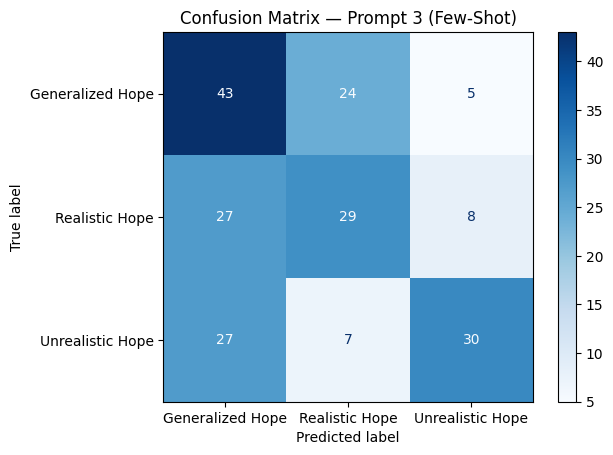

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# ===== seleccionar prompt =====
PROMPT_COL = "pred_prompt3"

# ===== etiquetas reales =====
y_true = finMulti["multiclass"]

# ===== predicciones mapeadas =====
y_pred = finMulti[PROMPT_COL].apply(map_for_eval)

labels = [
    "Generalized Hope",
    "Realistic Hope",
    "Unrealistic Hope"
]

cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Prompt 3 (Few-Shot)")
plt.show()


In [18]:
# ============================
# Mostrar ejemplos por clase
# ============================

def show_examples(df, label, n=10, seed=42):
    print(f"\n{'='*50}")
    print(f"🔹 {label.upper()} — {n} examples")
    print(f"{'='*50}\n")

    subset = df[df["multiclass"] == label].sample(
        n=min(n, (df["multiclass"] == label).sum()),
        random_state=seed
    )

    for i, text in enumerate(subset["text"], start=1):
        print(f"{i}. {text}\n")


# ---------- Ejecutar ----------
show_examples(finMulti, "Generalized Hope", n=10)
show_examples(finMulti, "Realistic Hope", n=10)



🔹 GENERALIZED HOPE — 10 examples

1. “Anytime we play, it’s going to be a good ballgame, and the fans just anticipate that,” Aaron Judge said of the Yankees and the Astros. “They bring their energy from the first pitch on, and that’s what you love.” #URL#

2. #USER# May Allah bless you our hero❤️
You will be successful with Allah's kun InshaAllah ❤️🌼

3. How can I love you more than I do already...am blessed to have you as a sister....one of the many gifts #USER# brought to my life.@Bridgetsluv I love you and I wish you all u wish for yourself. Happy blessed birthday sweetheart 💗 💓 🎊🎉🎁 Cheers 🍻 to new beginnings #URL#

4. the world can change. it may not turn out well. pain and suffering may not disappear. but... i wanna believe in our possibilities!

5. #USER# Thanks. This is the kind of info I was hoping for. I will keep this in mind when planning. Leeds fans are the best fans! #ALAW #MOT

6. Three announcements today at the UN Ocean Conference from Portugal, Uruguay and the Dominic